# Bandit Sequence Design

Design 60 6-base RBS sequences based on the bandit recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from sklearn.manifold import TSNE
#import seaborn as sns
from itertools import product
import math

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df.head()

,A,B,C
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626


In [3]:
df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 3)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

## Construct feature spaces

would be 'AAGT' + 6-base + 'GGA' 

@Maciej: to determine the seq other than the 6-base.

In [6]:
# create all combos


combos = []
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [7]:
todesign_data = np.asarray(list(zip(combos, labels)))

## Setting


In [8]:
embedding = 'label'
kernel = [spectrum_kernel, spectrum_kernel_pw]
string_kernel_flag = True

## Recommendations with GPUCB

60
[2235 3037 2735 1979 2720 2605 2634 3835 3770 3000 3067 3055 2732 2935 2986
 2734 3640 2699 2795 3042 2183 2810 2794 2746 3051 2811 2601 2733 2778 2781
  682 2978 2218 2721 3822 4095 2955 2047 2210 2594 2722 2186 2798 3754 2698
 2602 2603 3003 2762 3549 3071 2187 2184 3019 2729 1706 2600 2731 2728 2730]


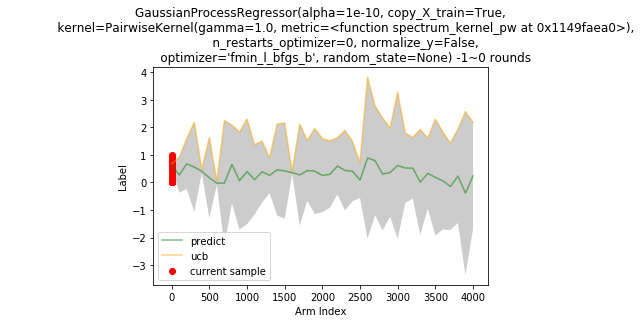

In [9]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

## Similarity vs Prediction

In [10]:
all_data = np.concatenate((data, todesign_data))
all_env = Rewards_env(all_data, embedding)
if len(kernel) == 1:
    kernel_matrix = kernel.__call__(all_env.embedded)
else:
    kernel_matrix = kernel[0](all_data[:,0])

In [11]:
kernel_matrix

array([[26, 17, 23, ...,  7,  6,  7],
       [17, 20, 19, ...,  6,  5,  6],
       [23, 19, 26, ...,  7,  6,  7],
       ..., 
       [ 7,  6,  7, ..., 30, 27, 36],
       [ 6,  5,  6, ..., 27, 30, 36],
       [ 7,  6,  7, ..., 36, 36, 50]], dtype=int64)

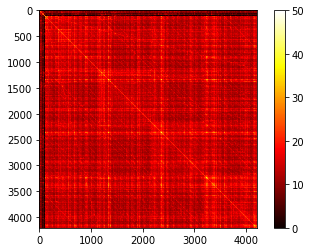

In [12]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.colorbar()
plt.show()

### TSNE

In [13]:
tsne = TSNE(metric = 'precomputed')
X_embedded = tsne.fit_transform(kernel_matrix)

In [14]:
X_embedded

array([[ 2.92181359, -2.88551993],
       [ 0.05348245, -2.94223156],
       [ 2.96091022, -2.94489266],
       ..., 
       [ 2.27403777, -1.21864049],
       [ 1.73961784, -1.71533006],
       [ 1.60930175, -0.8601596 ]])

### Save to file

In [22]:
import pickle

with open('spectrum.pickle', 'wb') as handle:
    pickle.dump((agent, kernel_matrix, X_embedded, all_data), handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot

In [24]:
similar_seqs = []

for i, idx_i in enumerate(X_embedded[113:]):
    for j, idx_j in enumerate(X_embedded[:113]):
        if np.linalg.norm(X_embedded[i]- X_embedded[j]) ** 2 <= 0.02:
            similar_seqs.append(i)
            break
            
len_sim = len(similar_seqs)
len_sim

566

In [25]:
similar_seqs = np.asarray(similar_seqs)

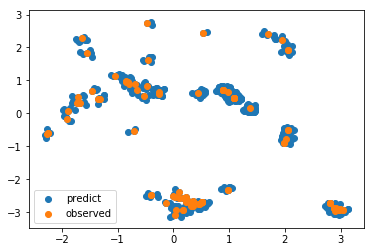

In [26]:
plt.scatter(X_embedded[similar_seqs, 0], X_embedded[similar_seqs,1], label = 'predict')
plt.scatter(X_embedded[:113,0], X_embedded[:113,1], label = 'observed')
plt.legend()

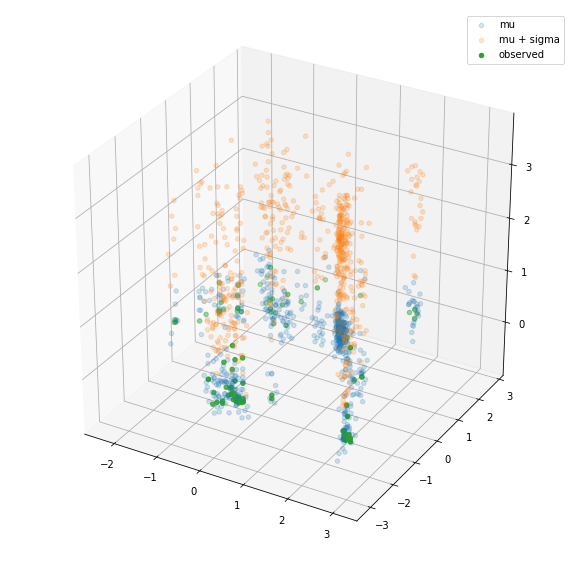

In [27]:
from mpl_toolkits import mplot3d
#%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
#X, Y = np.meshgrid(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1])
#ax.plot_surface(X,Y, agent.mu[similar_seqs].reshape(len_sim,1), label = 'mu', rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.scatter3D(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1], agent.mu[similar_seqs], label = 'mu', alpha = 0.2)
ax.scatter3D(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1], (agent.mu + agent.sigma)[similar_seqs], label = 'mu + sigma', alpha = 0.2)
ax.scatter3D(X_embedded[:113,0], X_embedded[:113,1], list(all_data[:113,1]), label = 'observed')
plt.legend()

### Convert to RBS seq

In [19]:
todesign_data[np.asarray(rec_arms),0]

array(['TTTAAGACACTCTTATACAT', 'TTTAAGACTTGTGTATACAT',
       'TTTAAGACCCCTTTATACAT', 'TTTAAGAGTCTCTTATACAT',
       'TTTAAGACCCCAATATACAT', 'TTTAAGACCACTGTATACAT',
       'TTTAAGACCGACCTATACAT', 'TTTAAGATCTTCTTATACAT',
       'TTTAAGATCCTCCTATACAT', 'TTTAAGACTCTCATATACAT',
       'TTTAAGACTTTCTTATACAT', 'TTTAAGACTTCTTTATACAT',
       'TTTAAGACCCCTATATACAT', 'TTTAAGACTGTGTTATACAT',
       'TTTAAGACTCCCCTATACAT', 'TTTAAGACCCCTCTATACAT',
       'TTTAAGATCATCATATACAT', 'TTTAAGACCCACTTATACAT',
       'TTTAAGACCTCCTTATACAT', 'TTTAAGACTTCACTATACAT',
       'TTTAAGACACAGTTATACAT', 'TTTAAGACCTTCCTATACAT',
       'TTTAAGACCTCCCTATACAT', 'TTTAAGACCCTCCTATACAT',
       'TTTAAGACTTCCTTATACAT', 'TTTAAGACCTTCTTATACAT',
       'TTTAAGACCACCGTATACAT', 'TTTAAGACCCCTGTATACAT',
       'TTTAAGACCTGCCTATACAT', 'TTTAAGACCTGTGTATACAT',
       'TTTAAGAACCCCCTATACAT', 'TTTAAGACTCCACTATACAT',
       'TTTAAGACACCCCTATACAT', 'TTTAAGACCCCAGTATACAT',
       'TTTAAGATCTCTCTATACAT', 'TTTAAGATTTTTTTATACAT',
       'TT

In [20]:
'''
onehot_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
onehot_dict = {'1000': 'A',
               '0100': 'C',
               '0010': 'G',
               '0001': 'T'}

rbs_seqs = []

for seq in onehot_seqs:
    rbs_seq = []
    for i in range(int(len(seq)/4)):
        start = i * 4
        end = start + 4
        s = seq[start:end]
        rbs_seq.append(onehot_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)
    
rbs_seqs
'''

"\nonehot_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]\nonehot_dict = {'1000': 'A',\n               '0100': 'C',\n               '0010': 'G',\n               '0001': 'T'}\n\nrbs_seqs = []\n\nfor seq in onehot_seqs:\n    rbs_seq = []\n    for i in range(int(len(seq)/4)):\n        start = i * 4\n        end = start + 4\n        s = seq[start:end]\n        rbs_seq.append(onehot_dict[s])\n    rbs_seq = ''.join(rbs_seq)\n    rbs_seqs.append(rbs_seq)\n    \nrbs_seqs\n"